In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def crop_brain_tumor(image):
    """
    Crops brain tumor from MRI images by removing extra black regions.
    Works with RGB and BGR images.
    """
    if image is None:
        raise ValueError("Image is None. Please check file path.")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to create mask
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)

    # Morphological operations
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image  # Fallback: return original image if no contour found

    # Get the largest contour (brain region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Crop the image
    cropped_img = image[y:y+h, x:x+w]
    return cropped_img


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

def preprocess_and_crop(img):
    """
    Function for ImageDataGenerator preprocessing_function.
    """
    img = img.astype(np.uint8)  # Convert to uint8 for cv2
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    cropped = crop_brain_tumor(img)
    cropped = cv2.resize(cropped, (150, 150))  # Resize back to model input
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)  # Convert back to RGB
    return cropped / 255.0  # Normalize


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,  # 👈 Add cropping
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,  # 👈 Add cropping
    validation_split=0.2
)
data_path = "C:/Users/agamb/Desktop/Project/Brain Tumor Data Set"

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# --- Load VGG19 with pretrained weights ---
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# --- Freeze base layers (so pretrained features remain intact) ---
for layer in vgg.layers:
    layer.trainable = False

# --- Add custom classification layers ---
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# --- Final Model ---
model_vgg19 = Model(inputs=vgg.input, outputs=predictions)

# --- Compile ---
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# --- Train ---
history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

# --- Evaluate ---
val_loss, val_acc = model_vgg19.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


c:\Users\agamb\Desktop\Brain_Tumor\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5591 - loss: 0.7187 - val_accuracy: 0.6246 - val_loss: 0.6194
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6736 - loss: 0.5940 - val_accuracy: 0.6736 - val_loss: 0.5859
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7137 - loss: 0.5509 - val_accuracy: 0.7029 - val_loss: 0.5618
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.7261 - loss: 0.5321 - val_accuracy: 0.7051 - val_loss: 0.5516
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7463 - loss: 0.5087 - val_accuracy: 0.7356 - val_loss: 0.5335
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7462 - loss: 0.4988 - val_accuracy: 0.7465 - val_loss: 0.5186
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 219s 950ms/step - accuracy: 0.7622 - loss: 0.4873 - val_accuracy: 0.7530 - val_loss: 0.5151
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 187s 811ms/step - accuracy: 0.7852 - loss: 0.4688 - va

In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img = image.load_img('./Brain Tumor Data Set/Brain Tumor/Cancer (198).jpg', target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

In [8]:
prediction = model_vgg19.predict(img_array)

# Binary classification (0: No Tumor, 1: Tumor)
if prediction[0][0] > 0.5:
    print("Tumor Detected")
else:
    print("No Tumor Detected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
No Tumor Detected


231/231 ━━━━━━━━━━━━━━━━━━━━ 135s 582ms/step


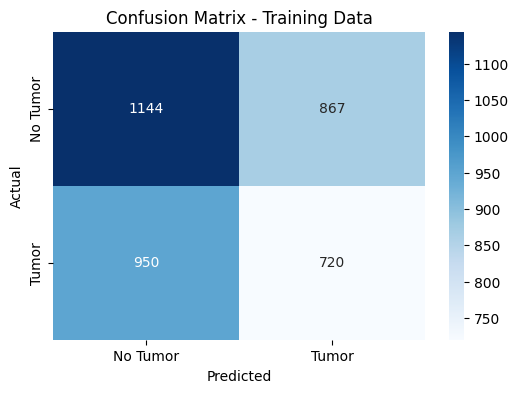

Training Data Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.55      0.57      0.56      2011
       Tumor       0.45      0.43      0.44      1670

    accuracy                           0.51      3681
   macro avg       0.50      0.50      0.50      3681
weighted avg       0.50      0.51      0.51      3681

58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 567ms/step


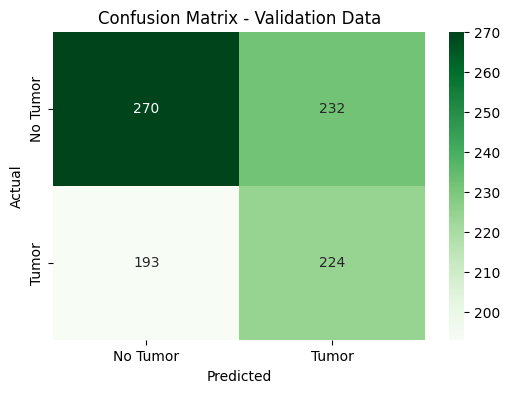

Validation Data Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.58      0.54      0.56       502
       Tumor       0.49      0.54      0.51       417

    accuracy                           0.54       919
   macro avg       0.54      0.54      0.54       919
weighted avg       0.54      0.54      0.54       919



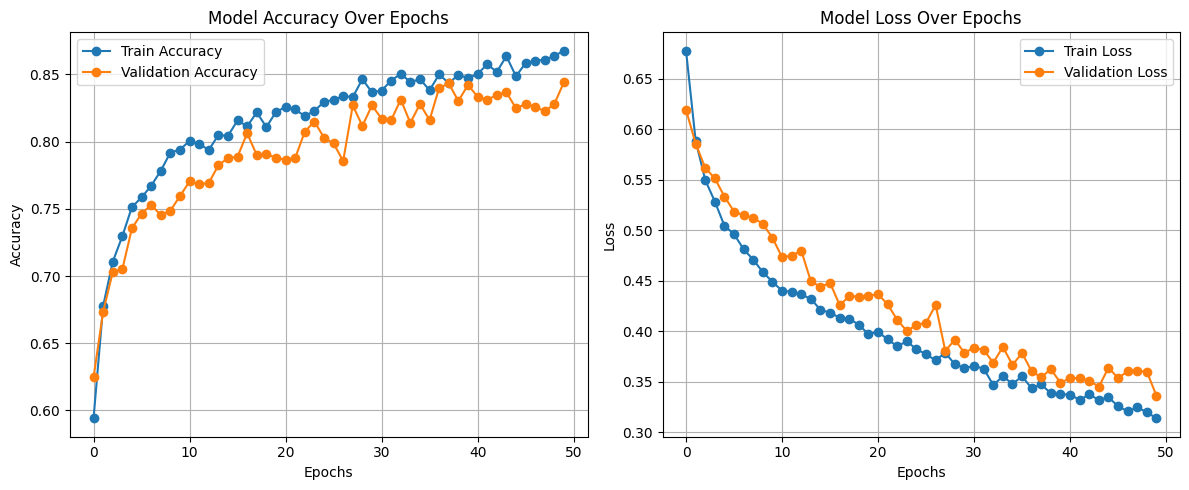

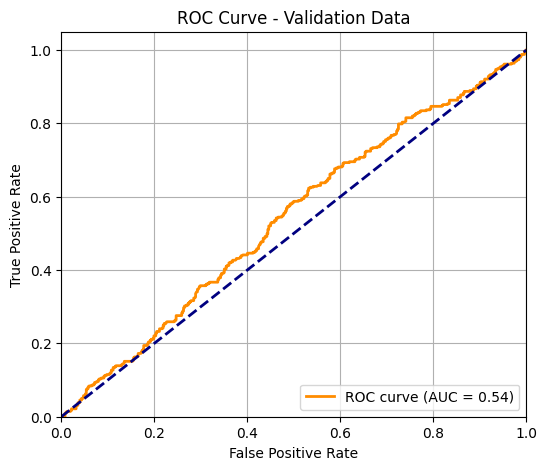

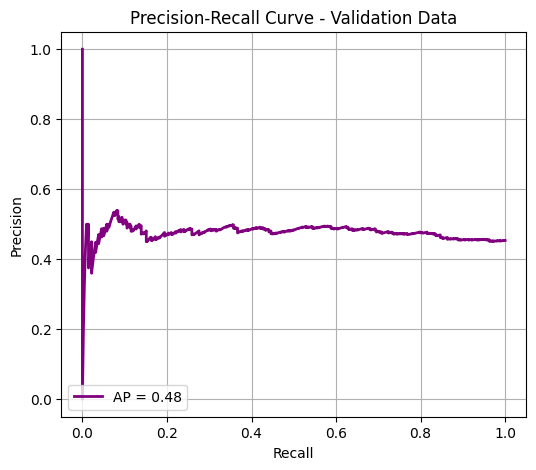

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

# ---- Confusion Matrix for Training Data ----
y_train_true = train_generator.classes
y_train_pred_probs = model_vgg19.predict(train_generator)
y_train_pred = (y_train_pred_probs > 0.5).astype(int).reshape(-1)

cm_train = confusion_matrix(y_train_true, y_train_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Training Data Classification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=['No Tumor', 'Tumor']))

# ---- Confusion Matrix for Validation Data ----
y_val_true = val_generator.classes
y_val_pred_probs = model_vgg19.predict(val_generator)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).reshape(-1)

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Validation Data Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['No Tumor', 'Tumor']))

# ---- Line Plots for Accuracy and Loss ----
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_vgg19.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_vgg19.history['loss'], label='Train Loss', marker='o')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(y_val_true, y_val_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---- Precision-Recall Curve ----
precision, recall, _ = precision_recall_curve(y_val_true, y_val_pred_probs)
avg_precision = average_precision_score(y_val_true, y_val_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Data')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [10]:
model_vgg19.save('brain_tumor_model_crop.h5')  